In [2]:
import wandb
import pandas as pd
from utils.utils import plot_confidence_error, expected_calibration_error, calculate_macro_ece, calculate_auroc, calculate_auroc
from utils.utils import extract_texts_and_confidences
import re
from utils.utils import compute_exact_match, compute_f1
import math

In [117]:
runs = pd.read_csv("csv/inference.csv")
runs = runs[runs["prompt"] == "multistep"]
#runs = runs[runs["model"]=="gpt-4o"]
#runs = runs[runs["dataset"]=="HotpotQA"]

project_name = "uncertainty-reimplimentation-results"
job_type = "eval-aggregation"

args = {
    
}
runs

,Name,ID,dataset,model,prompt
1,volcanic-blaze-770,uo2u5m33,HotpotQA,DeepSeek-V3,multistep
5,brisk-sun-792,l1vy1axf,MuSiQue,DeepSeek-V3,multistep
8,silvery-surf-742,ck1php1l,2WikiMultihopQA,DeepSeek-V3,multistep
13,fallen-surf-748,230q321e,2WikiMultihopQA,Llama-3.3-70B,multistep
14,lemon-sea-784,2h1uprtd,HotpotQA,Llama-3.3-70B,multistep
15,comic-dew-786,ukkob161,MuSiQue,Llama-3.3-70B,multistep
24,fearless-vortex-732,1xowlg3z,MuSiQue,gpt-4o,multistep
25,rose-energy-724,gr7ngjjq,HotpotQA,gpt-4o,multistep
33,giddy-forest-711,ul91s1f1,2WikiMultihopQA,gpt-4o,multistep
39,leafy-bird-804,cf7cb2ph,2WikiMultihopQA,gpt-4o-mini,multistep


In [3]:
methods = {
    "min" : lambda x: min(x),
    "avg" : lambda x: sum(x) / len(x),
    "prod" : lambda x: math.prod(x),
    "num_steps" : lambda x: x[-1]** len(x),
    "final" : lambda x: x[-1]
}

def process(response):
    _, confidences = extract_texts_and_confidences(response)
    confidence = methods[aggregation_method](confidences)

    return confidence

wandb: Currently logged in as: lukas-hofbauer (hofbauer) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


wandb:   1 of 1 files downloaded.  

KeyboardInterrupt



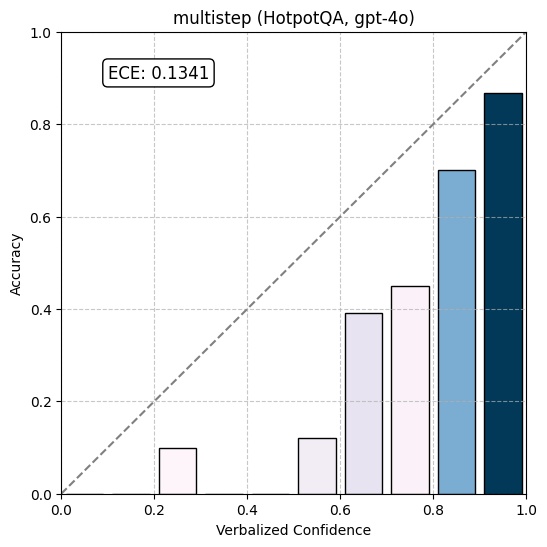

In [16]:
for run_id in runs["ID"]:
    for aggregation_method in ["final"]: #["min", "avg", "prod", "num_steps"]:
        run = wandb.init(
            project=project_name,
            job_type=job_type,
            config={"aggregation" : aggregation_method},
            tags=["aggregation"]
        )
        
        table_artifact = run.use_artifact(f"run-{run_id}-table:v0")
        table: pd.DataFrame = table_artifact.get("table").get_dataframe()
        run.config.update(table_artifact.logged_by().config)

        table["confidence"] = table["response"].apply(process)

        fig, _ = plot_confidence_error(
            table["gpt_eval"],
            table["confidence"],
            title=f"{run.config.prompt} ({run.config.dataset}, {run.config.model})",
            ylabel="Accuracy",
            xlabel="Verbalized Confidence",
        )
        
        f1_score = table["f1"].mean()
        accuracy = table["gpt_eval"].mean()
        ece_score = expected_calibration_error(table["gpt_eval"], table["confidence"])
        auroc_score = calculate_auroc(table["gpt_eval"], table["confidence"])
        macro_ece_score = calculate_macro_ece(table, collumn="gpt_eval")
        
        wandb.log(
            {
                "f1": f1_score,
                "acc": accuracy,
                "ece": ece_score,
                "auroc": auroc_score,
                "macro_ece": macro_ece_score,
            }
        )
        
        wandb.log({"calibration_plot": wandb.Image(fig)})
        wandb.finish()

Dataset: HotpotQA
Model: DeepSeek-V3


wandb:   1 of 1 files downloaded.  


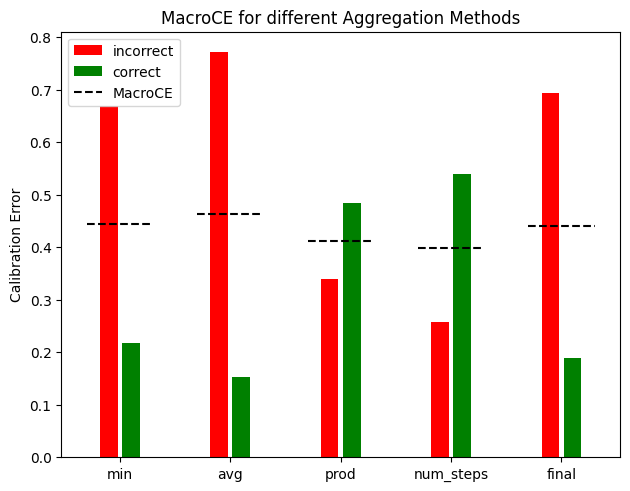

Dataset: MuSiQue
Model: DeepSeek-V3


wandb:   1 of 1 files downloaded.  


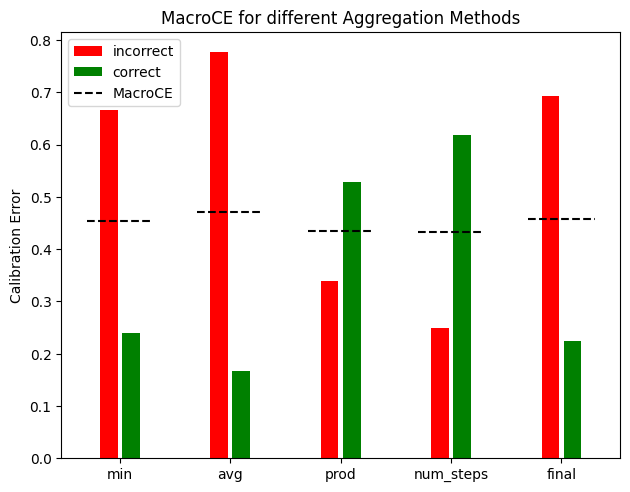

Dataset: 2WikiMultihopQA
Model: DeepSeek-V3


wandb:   1 of 1 files downloaded.  


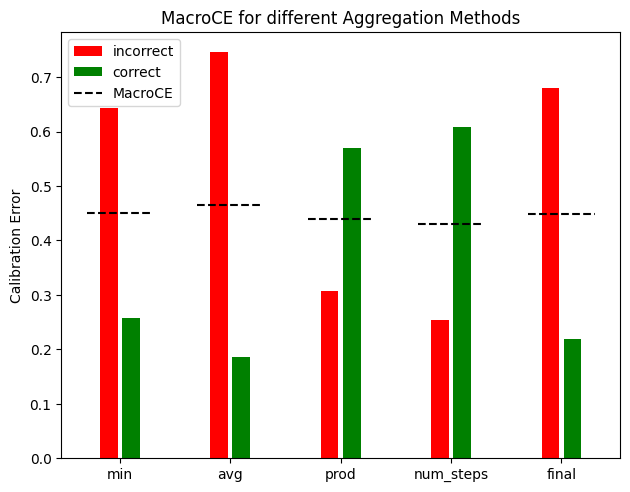

Dataset: 2WikiMultihopQA
Model: Llama-3.3-70B


wandb:   1 of 1 files downloaded.  


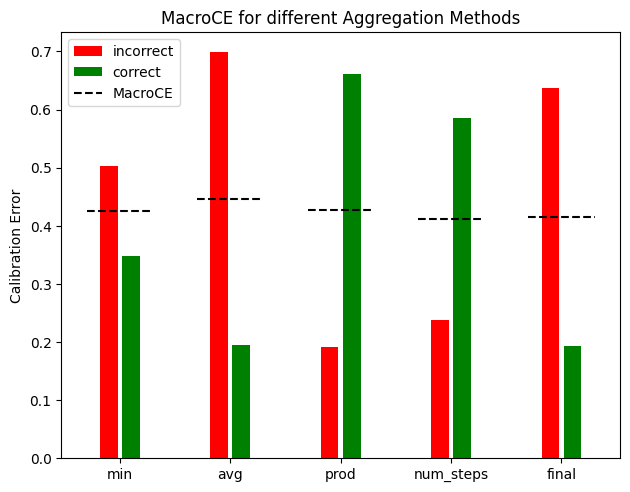

Dataset: HotpotQA
Model: Llama-3.3-70B


wandb:   1 of 1 files downloaded.  


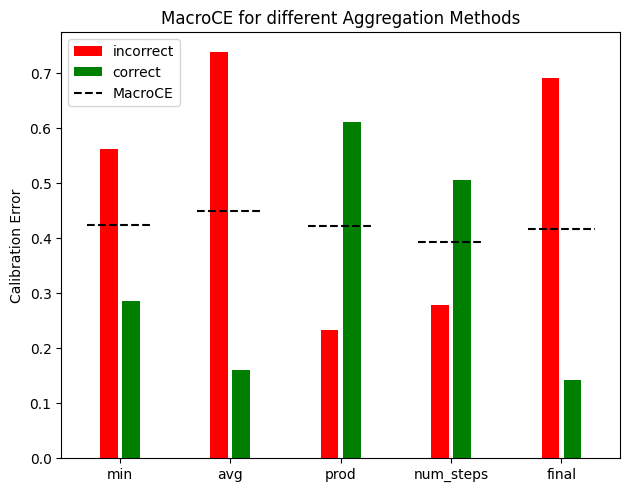

Dataset: MuSiQue
Model: Llama-3.3-70B


wandb:   1 of 1 files downloaded.  


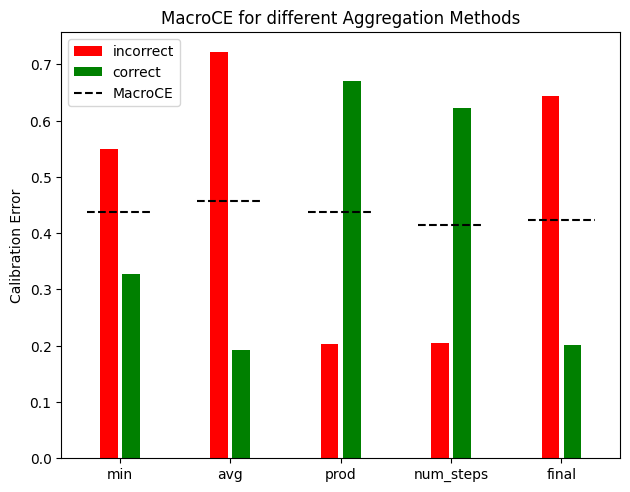

Dataset: MuSiQue
Model: gpt-4o


wandb:   1 of 1 files downloaded.  


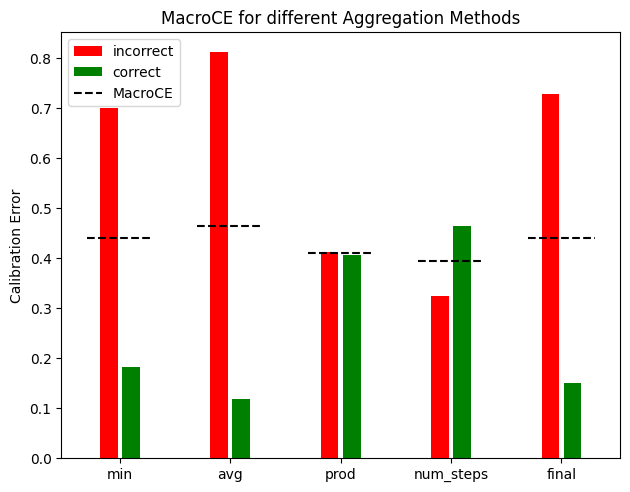

Dataset: HotpotQA
Model: gpt-4o


wandb:   1 of 1 files downloaded.  


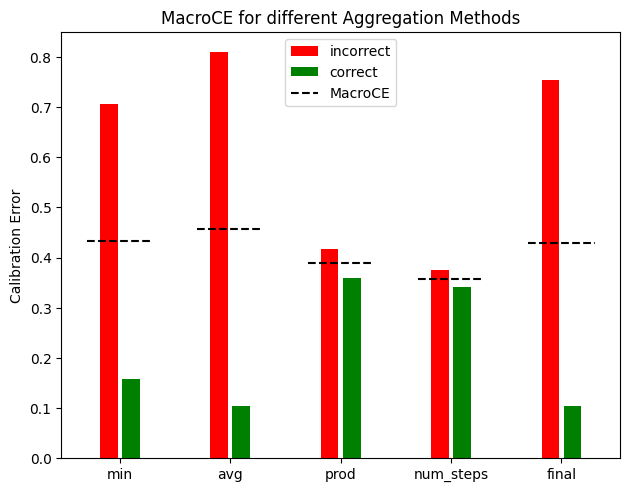

Dataset: 2WikiMultihopQA
Model: gpt-4o


wandb:   1 of 1 files downloaded.  


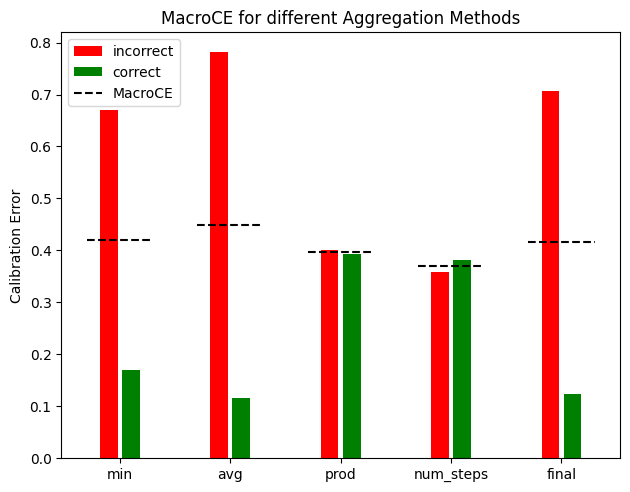

Dataset: 2WikiMultihopQA
Model: gpt-4o-mini


wandb:   1 of 1 files downloaded.  


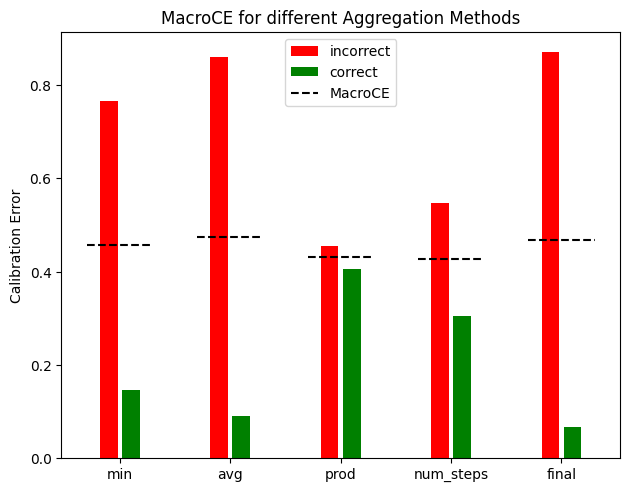

Dataset: HotpotQA
Model: gpt-4o-mini


wandb:   1 of 1 files downloaded.  


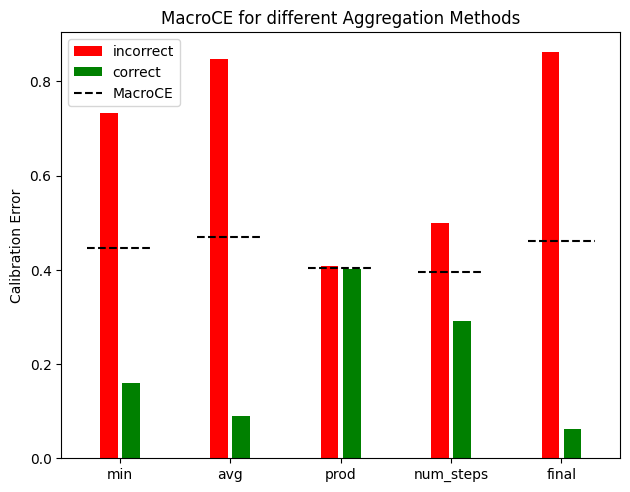

Dataset: MuSiQue
Model: gpt-4o-mini


wandb:   1 of 1 files downloaded.  


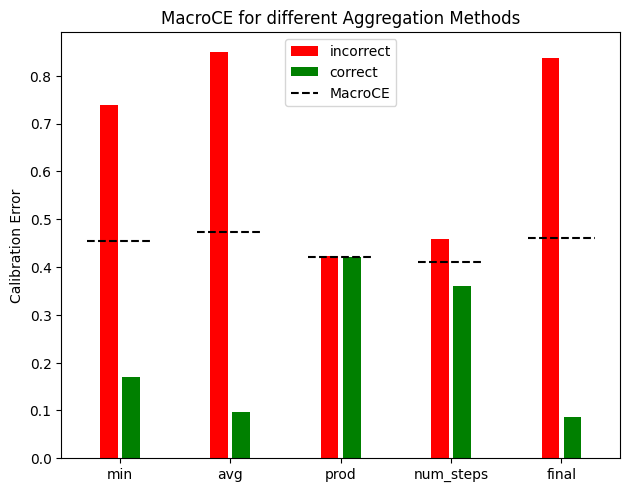

In [170]:
api = wandb.Api()


aggregation_methods = ["min", "avg", "prod", "num_steps", "final"]

data = []

for i, row in runs.iterrows():
    eces = []
    aurocs = []
    macro_eces = []
    labels = []
    confs = []
    print("Dataset: " + str(row["dataset"]))
    print("Model: " + str(row["model"]))
    table_artifact = api.artifact(f"{project_name}/run-{row["ID"]}-table:v0")
    table: pd.DataFrame = table_artifact.get("table").get_dataframe()

    
    f1_score = table["f1"].mean()
    accuracy = table["gpt_eval"].mean()
    
    for aggregation_method in aggregation_methods:

        table[aggregation_method] = table["response"].apply(process)

        ece = expected_calibration_error(table["gpt_eval"], table[aggregation_method])
        eces.append(ece)
        
        auroc_score = calculate_auroc(table["gpt_eval"], table[aggregation_method])
        aurocs.append(auroc_score)


        table["confidence"] = table[aggregation_method]
        
        macro_ece_score = calculate_macro_ece(table, collumn="gpt_eval", give_array=True)
        macro_eces.append(macro_ece_score)

        avg_conf = table[aggregation_method].mean()
        confs.append(avg_conf)

        data.append(
            {
                "model" : row["model"],
                "dataset" : row["dataset"],
                "aggregation" : aggregation_method,
                "acc" : accuracy,
                "ece": ece,
                "macro_ce" : macro_ece_score
            }
        )
    mod = row["model"].split(".")[0]
    print_graphs(f"images/agg/{mod}-{row["dataset"]}")

In [166]:
import matplotlib as mpl

def print_graphs(path=None):
    print_macro_ce(path)
    #print_ece()

def print_macro_ce(path=None):
    colors = ['red', 'green']
    offsets = [0, 1]
    group_offset = 5
    
    xticks = []
    
    for i, (label, values, ece) in enumerate(zip(aggregation_methods, macro_eces, eces)):
        x = [o + i * group_offset for o in offsets]
        xticks.append(sum(x) / len(x))  # center of the group
    
        # Average line
        avg = sum(values) / len(values)
        if i == 0:
            plt.bar(x, values, color=colors, label=["incorrect", "correct"])
            plt.hlines(avg, x[0]-1, x[-1]+1, colors='black', linestyles='dashed', label="MacroCE")
            #plt.hlines(ece, x[0]-1, x[-1]+1, colors='blue',  label="ECE")
    
        else:
            plt.hlines(avg, x[0]-1, x[-1]+1, colors='black', linestyles='dashed')
            plt.bar(x, values, color=colors)
            #plt.hlines(ece, x[0]-1, x[-1]+1, colors='blue')
            
    plt.xticks(xticks, aggregation_methods)
    plt.ylabel("Calibration Error")
    plt.tight_layout()
    plt.title("MacroCE for different Aggregation Methods")
    plt.legend()
    if path:
        plt.savefig(path)
    plt.show()

def print_ece():
    cmap = mpl.colormaps["tab10"] # or 'viridis', 'plasma', 'Set3', etc.
    colors = cmap.colors[:len(aggregation_methods)]
    plt.bar(aggregation_methods, eces, color=colors)
    plt.show()

    

In [140]:
df

,Name,aggregation,dataset,model,acc,auroc,ece,f1,macro_ece
0,pleasant-water-961,final,HotpotQA,gpt-4o,0.723000,0.786075,0.134070,0.638560,0.429275
1,exalted-sound-948,final,MuSiQue,gpt-4o-mini,0.239000,0.681613,0.616520,0.192543,0.461566
2,balmy-firefly-947,final,HotpotQA,gpt-4o-mini,0.570000,0.740045,0.335020,0.494704,0.462120
3,usual-rain-946,final,2WikiMultihopQA,gpt-4o-mini,0.418000,0.663516,0.479020,0.389453,0.468337
4,volcanic-haze-945,final,2WikiMultihopQA,gpt-4o,0.610000,0.755187,0.199840,0.543032,0.415642
...,...,...,...,...,...,...,...,...,...
68,rose-paper-747,NaN,HotpotQA,gpt-4o-mini,0.584000,0.733725,0.306050,0.492207,0.449658
69,treasured-darkness-739,NaN,HotpotQA,Llama-3.3-70B,0.649547,0.818335,0.184924,0.569488,0.386205
70,distinctive-morning-731,NaN,MuSiQue,gpt-4o,0.345000,0.709530,0.473700,0.273613,0.428756
71,elated-frog-723,NaN,HotpotQA,gpt-4o,0.733734,0.787768,0.165015,0.645643,0.414092


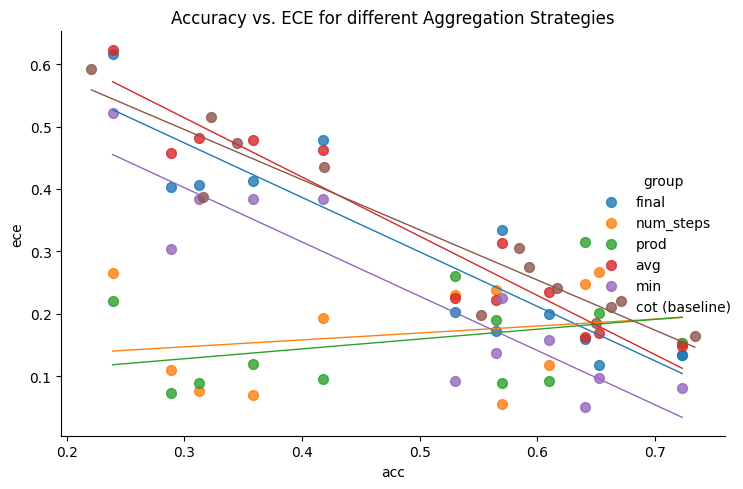

In [3]:
df = pd.read_csv("csv/eval_agg.csv")

import seaborn as sns
import matplotlib.pyplot as plt
import math

# Make sure 'Name', 'aggregation', and 'model' are strings
df["aggregation"] = df["aggregation"].fillna("cot (baseline)")
df['group'] = df["aggregation"]

# Plot
sns.lmplot(
    data=df,
    x='acc',
    y='ece',
    hue='group',
    ci=None,
    markers='o',
    scatter_kws={'s': 50},
    line_kws={'linewidth': 1},
    height=5,
    aspect=1.2
)

plt.title("Accuracy vs. ECE for different Aggregation Strategies")
plt.tight_layout()
plt.savefig("images/agg/acc_v_ece.png")
plt.show()

([<matplotlib.axis.XTick at 0x7f6cc11902d0>,
 [Text(1, 0, 'min'),
  Text(6, 0, 'avg'),
  Text(11, 0, 'prod'),
  Text(16, 0, 'num_steps'),
  Text(21, 0, 'final')])

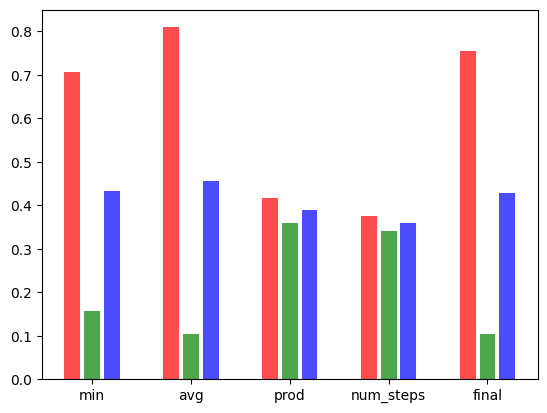

In [47]:
import matplotlib.pyplot as plt


offsets = [0, 1, 2]
group_offset = 5

for i, label in enumerate(aggregation_methods):
    current_offsets = [o + i* group_offset for o in offsets]
    colors = ["red", "green", "blue"]
    plt.bar(current_offsets, macro_eces[i], color=colors, alpha=0.7)

plt.xticks([1+5*i for i in range(len(aggregation_methods))], aggregation_methods)

In [13]:
table.confidence

In [14]:
run = wandb.init(
    project=project_name,
    job_type=job_type,
    config={"aggregation" : aggregation_method}
)

table_artifact = run.use_artifact(f"run-{run_id}-table:v0")
table: pd.DataFrame = table_artifact.get("table").get_dataframe()
run.config.update(table_artifact.logged_by().config)

wandb:   1 of 1 files downloaded.  


In [21]:
table["confidence"] = table["response"].apply(process)
table

,id,question,answer,type,level,response,prediction,confidence,f1,em
0,5ae3cfe05542990afbd1e1e3,"Which airport is located in Maine, Sacramento ...",Knox County Regional Airport,comparison,medium,Step 1: Identify the locations of each airport...,Knox County Regional Airport,1.00,1.000000,1
1,5abc1abf5542993a06baf87f,Peter Hobbs founded the company that is based ...,Failsworth,bridge,medium,Step 1: Identify Peter Hobbs and his company. ...,Altrincham,0.40,0.000000,0
2,5ac250eb5542992f1f2b384f,What direction does the river that Austrolebia...,north to south,bridge,medium,Step 1: Austrolebias bellottii is a species of...,[No specific direction due to temporary habita...,0.60,0.181818,0
3,5a81a60455429903bc27b990,Were both Gabriela Mistral and G. K. Chesterto...,yes,comparison,medium,Step 1: Gabriela Mistral was a Chilean poet an...,yes,0.95,1.000000,1
4,5a70fb2d5542994082a3e482,"What city, other than San Jose del Cabo, is at...",Cabo San Lucas,bridge,medium,Step 1: The Baja California Peninsula is locat...,Cabo San Lucas,1.00,1.000000,1
...,...,...,...,...,...,...,...,...,...,...
995,5a7f8a675542992097ad2f98,"Which school has undergone more name changes, ...",The College of New Jersey,comparison,medium,Step 1: Kettering University was formerly know...,Neither (both have the same number of name cha...,0.70,0.166667,0
996,5a77af405542992a6e59df84,"The 2022 FIFA World Cup will be held in Qatar,...",23rd FIFA World Cup,bridge,easy,Step 1: The 2022 FIFA World Cup is held in Qat...,2026 FIFA World Cup,1.00,0.750000,0
997,5a78b93d55429974737f7863,"What theme park has a land area of 25 ha, whic...",Enchanted Kingdom,bridge,medium,"Step 1: First, identify that 25 ha (hectares) ...",Pandora - The World of Avatar,0.75,0.000000,0
998,5a79098355429970f5fffe2a,"Q: Who is older, Wayne Black or Byron Black?",Byron Black,comparison,medium,Step 1: Wayne Black and Byron Black are both p...,Byron Black,0.80,1.000000,1


In [ ]:
table = pd.concat([table, pd.DataFrame(list(table.apply(process, axis=1)))], axis=1)

table = table.dropna()  ## remove missing rows

fig, _ = plot_confidence_error(
    table["em"],
    table["confidence"],
    title=f"{run.config.prompt} ({run.config.dataset}, {run.config.model})",
    ylabel="Accuracy",
    xlabel="Verbalized Confidence",
)



f1_score = table["f1"].mean()
accuracy = table["em"].mean()
ece_score = expected_calibration_error(table["em"], table["confidence"])
auroc_score = calculate_auroc(table["em"], table["confidence"])
macro_ece_score = calculate_macro_ece(table)

wandb.log(
    {
        "f1": f1_score,
        "acc": accuracy,
        "ece": ece_score,
        "auroc": auroc_score,
        "macro_ece": macro_ece_score,
    }
)

wandb.log({"calibration_plot": wandb.Image(fig)})
wandb.finish()